# Cleaning the Continuum Data

In [9]:
#Run me first! And run me everytime you open this document!  
#Hint: You can use shift + enter to run the selected cell.  

#General Imports
import numpy as np 
import os 

#CASA TASKS IMPORTS 
import casatasks #This is CASA in a form that we can use in this Jupyter Notebook
from casatasks import tclean #this is the cleaning function we will use
from casatasks import exportfits
from casatasks import imhead
from casatasks import imstat
from casatasks import listobs
from casatasks import uvcontsub
from casatasks import imhead
from casatasks import split

#PLOT IMPORTS 
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
from IPython.display import Video
from IPython.display import HTML

# Plotting including Reading Rainbow
#from mom0_bodyV2 import mom0
from plot_all_V2 import plotall
from plot_cont import plotCont
from movie import movie
from BeamSize import beamsize

print('Important Imports Imported')

Important Imports Imported


# How to Use this Guide: 
This guide is designed to be a step by step guide on how we can clean the data. Each cell must be run in order. If the cells are run out of order, you will likely get errors like "file/directory does not exist". 

Now that we know the basics, let's clean the continuum! 

We will start with the continuum data. This is contained within the repository `MWC_480_CO_220GHz.bin_30s.ms.cont.cvel`. This is the observation from the telescope. 

In [10]:
# First Lets set our inputs
#########################################
#### DO Not Change these parameters #####
#########################################

msvis = 'MWC_480_CO_220GHz.bin_30s.ms.cvel' 
# This is our observation. It is the data we will image
avgvis= msvis 
contvis = msvis 
mask_name = './premadeMask/Continuum.mask' # This mask has been generated for you!
sn = 3.0 # this is our sigma level. We will use a threshold that is 3 sigma 
#times our noise level which we will calculate from our dirty image. 
field = '0'
spws = '0'
imsize = [400,400]
cell = '0.05arcsec'
weighting = 'briggs'
robust = 0.25
gridder = 'standard'
########################################


In [11]:
###### Give Your File A Name #######
# Change imgname to a string that 
imgname = 'continuum' #this will be the name of the file that is created. Change it to something memorable or descriptive. 
dirty_name = imgname+'.dirty'
clean_name = imgname+'.clean'

In [12]:
# First lets check if the continuum exists. If now we will generate it.
def flagcontinuum(msvis):
    # this will do a continuum subtraction in uv space
    # and will generate two to ms sets
    # 1) msvis.contsub, which is the continuum subtracted line
    # 2) msvis.cont, which is the continuum 
    # I will note, there is another function call 'flagdata', which is *technically* a more thorogh way 
    # to do continuum subtraction, but it's more finicky, and you have to define more parameters
    # so uvcontsub will work just fine, especially because we have such bright data. 
    uvcontsub(vis=msvis, outputvis=contvis  want_cont=True)
    split(vis=contvis,
    outputvis=avgvis,
    datacolumn='data',
    keepflags=False,
    width=200000) # Change width to be correct for your num of channels
    return
# This checks to see if the flagged data exists, if not it will generate it. 
if os.path.exists('%s.cont'%(msvis)):
        print('flagged ms already exists')
        pass
else:
        print('%s.cont does not exist. Generating it.' %(msvis) )
        flagcontinuum(msvis)
msvis = avgvis+'.cont'

flagged ms already exists


## Make the Dirty Image 
We are running the cleaning function, but not cleaning the data.
Why would we do that? This allows us to read the data and get some information out that we need to clean the data well. 
From the dirty data we can determine the noise level in the side channels before and after the emission we care about. The noise level will help us determine our `threshold`, or the level to which we will clean. 

In [13]:
# Make the Dirty Image 
tclean(vis=msvis,
           imagename= dirty_name,
           field=field,
           spw=spws,
           specmode='mfs',   # mfs is what tells clean to image a continuum
           deconvolver='hogbom', # Hogbom is standard for disks
           imsize=imsize,
           cell=cell,
           weighting=weighting,
           robust=robust,
           niter=0,
           threshold='1Jy',
           interactive=False,
           gridder=gridder)
print('dirty continuum generated')

dirty continuum generated


Let's Determine our noise level. 

In [16]:
#From the Dirty Image, now we know what the noise level in the data set is.

#Determine the parameters of the beam from the observation: 
bmax_obs = imhead(imagename=dirty_name+'.image',mode="get",hdkey="bmaj")['value']
bmin_obs = imhead(imagename=dirty_name+'.image',mode="get",hdkey="bmin")['value']
bpa_obs = imhead(imagename=dirty_name+'.image',mode="get",hdkey="bpa")['value']  
#Determine if bpa_obs is in radians or degrees. If in radians convert to degrees. 
if abs(bpa_obs) < 5.0:
    bpa_obs = bpa_obs*180.0/np.pi
else:
     bpa_obs = bpa_obs

inversemask = './premadeMask/antimask.clean.mask' # This is the reverse of the mask we use earlier.

# Calculate the noise. Here we use a CASA fuction imstat, image statistics, to determine what the noise level is. 
noise = imstat(dirty_name+'.image', mask= inversemask)['rms'][0]

#noise is given as the standard deviation of the brightness measurements in a channel. 
#It is standard to set threshold to 3 standard deviations, this generally gives a good level of noise in the side channel. 
thres = noise * sn  # noise level we calculated above times 3. 
print(thres) #Reported in janskys

RuntimeError: Input mask specification is incorrect: Image Expression: Parse error at or near '.'
Scanned so far:  at File: src/code/imageanalysis/ImageAnalysis/SubImageFactory.tcc, line: 289

In [ ]:
# Now we can clean the image to the threshold we just determined.  
tclean(vis=msvis,
           mask= mask_name,
           imagename= clean_name,
           field=field,
           spw=spws,
           specmode='mfs',
           deconvolver='hogbom',
           imsize=imsize,
           cell=cell,
           weighting=weighting,
           robust=robust,
           niter=10000,
           threshold=thres,
           interactive=False,
           gridder=gridder)
print('clean continuum generated')

Now we will export our imagaes to fits files. With the Fits files we can use Reading Rainbow to plot the images. 

In [ ]:
exportfits(imgname+'.dirty.image', fitsimage= imgname + '.dirty.fits', dropstokes = True)
exportfits(imgname+ '.clean.image', fitsimage= imgname+'.image.fits', dropstokes = True)
exportfits(imgname+ '.residual', fitsimage = imgname + '.residual.fits', dropstokes = True)
exportfits(imgname+'.mask', fitsimage = imgname + '.mask.fits', dropstokes = True)

In [ ]:
imname = imagename +'.image.fits' #name of file your want to make a video from 
svel = 5.1
cmap = 'viridis' #Color map 
window = 10.0 # arcsec extent of the window per channel
nchannels = 132#This is how many channels are plotted. 
movie(imname, nchannels, svel, cmap, window, fitsdata = False) 

HTML('<img src="movie.gif">')

In [ ]:
imname = imagename +'.dirty.fits' #name of file your want to make a video from 
svel = 5.1
cmap = 'viridis' #Color map 
window = 10.0 # arcsec extent of the window per channel
nchannels = 132#This is how many channels are plotted. 
movie(imname, nchannels, svel, cmap, window, fitsdata = False) 

HTML('<img src="movie.gif">')

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


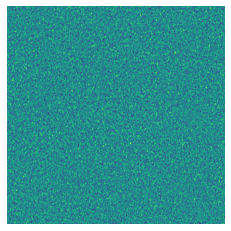

In [8]:
imname = imagename +'.residual.fits' #name of file your want to make a video from 
svel = 5.1
cmap = 'viridis' #Color map 
window = 10.0 # arcsec extent of the window per channel
nchannels = 132#This is how many channels are plotted. 
movie(imname, nchannels, svel, cmap, window, fitsdata = False) 

HTML('<img src="movie.gif">')

In [ ]:
from plot_cont import plotCont
imname = imgname + '.fits' # this needs to be a string, so have "" around the file name
maskname = maskname+ '.mask.fits' #Use one of the provided test masks 
svel = 5.1
cmap = 'viridis' #Color map 
window = 4.0 # arcsec extent of the window per channel
plotCont(imname, maskname, svel, cmap, window, fitsdata = True) 